## makemore -- mlp

following andrej karpathy's course (https://www.youtube.com/watch?v=TCH_1BHY58I)

his github: https://github.com/karpathy/makemore

### high level

this is a *word* level language model, and has a defined vocabulary size of *n* words. Each word is represented with a vector embedding.

predict the next word given the previous word. works by tuning the embedding vectors over time.

# <img src="./images/mlp.png" width="500" style="margin: 0 auto; display: block;"/>

- predict next word using 3 previous words
- *n-1* indices
- lookup table *C* is a *n x d* matrix, where *d* is the embedding dimension (30 in this case) -> first layer has *3 x 30* neurons
- hidden layer: tanh - its a hyperparameter (design choice upto designer of neural net), can be as large or small as one wants, but each neuron here connected to all the neurons in the prev layer + next layer
- output layer: *n* neurons, one for each word in the vocabulary

In [1]:
!curl -O https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
!pip install torch

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   576k      0 --:--:-- --:--:-- --:--:--  577k

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

words = open('names.txt', 'r').read().splitlines()

In [3]:
# building the vocab

chars = sorted(list(set("".join(words))))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# building the dataset. taking three chars at a time, and assigning the output label as the fourth char

block_size = 3 # context length
X, Y = [], []

for word in words:
    context = [0] * block_size
    # print(word)
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # the example
        # print(f'{"".join(itos[i] for i in context)} -> {ch}')
        context = context[1:] + [ix]
    # print()

X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape # each input to the neural net is 3 integers, and we have 228146 examples in total

(torch.Size([228146, 3]), torch.Size([228146]))

we now construct the lookup table *C*. shape will be *e x c x d* where *e* is the number of examples, *c* is the context length, and *d* is the embedding dimension

In [5]:
C = torch.randn((27, 2)) # 27 chars in the vocab, and each word is represented with a 2 dimensional vector
emb = C[X] # get all embeddings for the input simultaneously
emb.shape

torch.Size([228146, 3, 2])

we now construct the hidden layer

In [6]:
W1 = torch.randn((6, 100)) # 6 inputs to each neuron (3 words x 2 embedding dimensions) and 100 neurons in total (our choice)
b1 = torch.randn((100))

In [7]:
# do a little preprocessing to make matmul possible
# concatenate embeddings for each element in context
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

# the code below does the same thing elegantly, however not elegant from a memory/performance perspective because it creates a new tensor and copies the data
torch.cat(torch.unbind(emb, dim=1), dim=1)

# the code below does it even more elegantly, and does not create a new tensor, just modifies internal "view" of the tensor
# to see why, call tensor.storage() to see the internal storage of the tensor
emb.view(228146, 6)


tensor([[ 1.3784, -0.5127,  1.3784, -0.5127,  1.3784, -0.5127],
        [ 1.3784, -0.5127,  1.3784, -0.5127,  0.7695,  0.2416],
        [ 1.3784, -0.5127,  0.7695,  0.2416,  0.3726,  0.1939],
        ...,
        [ 0.4043, -1.3515,  0.4043, -1.3515, -1.4558,  1.3492],
        [ 0.4043, -1.3515, -1.4558,  1.3492,  0.4043, -1.3515],
        [-1.4558,  1.3492,  0.4043, -1.3515,  0.6392, -0.9029]])

In [8]:
# hidden state
# -1 is a wildcard dimension, and will be inferred from the context
h = emb.view(-1, 6) @ W1 + b1
h

tensor([[-4.4406, -2.6394, -0.2651,  ...,  2.5480, -0.1487,  2.1751],
        [-3.1099, -3.0843,  0.7339,  ...,  2.5466, -0.1923,  2.0609],
        [-2.0650, -2.8906,  0.2700,  ...,  0.8428,  0.4531,  2.0757],
        ...,
        [ 5.1155, -2.5685,  4.4229,  ...,  1.0521,  0.1396,  0.7499],
        [ 0.5299,  0.3261, -1.9245,  ..., -3.3464,  3.0530,  1.7042],
        [-3.0674,  1.6649,  1.8933,  ...,  4.9284, -2.4279, -2.1673]])

output layer

In [9]:
# 100 inputs to each neuron, and 27 neurons in total (one for each char)
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [10]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(probs.shape[0]), Y].log().mean()

# cross entropy loss gives the same output
# better because torch does not do the intermediate steps above and create unnecessary tensors
# does clustered mathematical operations

ce_loss = F.cross_entropy(logits, Y)

summary before training nn

In [11]:
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

3481

run the backward pass

In [12]:
for p in params:
    p.requires_grad = True

for _ in range(100):
    # running minibatches here to save time
    # the gradient is less accurate since # of examples is small but accurate enough
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD PASS
    emb = C[X[ix]]
    # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # BACKWARD PASS
    for p in params:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    for p in params:
        p.data += -0.1 * p.grad
    # print(loss.item())    

In [13]:
emb = C[X[ix]]
# to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[ix])
loss

tensor(3.2150, grad_fn=<NllLossBackward0>)

loss analysis -- how do we choose the best learning rate?

In [14]:
# reset cell
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn((100))
W2 = torch.randn((100, 27))
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]

In [15]:
# construct a list (1000 elements) of learning rates from 10^-3 to 1 to try
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [16]:
lri = []
lossi = []
lri_exp = []

for p in params:
    p.requires_grad = True

for i in range(1000):
    # running minibatches here to save time
    # the gradient is less accurate since # of examples is small but accurate enough
    ix = torch.randint(0, X.shape[0], (32,))

    # FORWARD PASS
    emb = C[X[ix]]
    # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # BACKWARD PASS
    for p in params:
        p.grad = None
    loss.backward()

    # UPDATE WEIGHTS
    lr = lrs[i]
    for p in params:
        p.data += -lr * p.grad
    # print(loss.item())

    # TRACKING
    lri.append(lr)
    lri_exp.append(lre[i])
    lossi.append(loss.item())


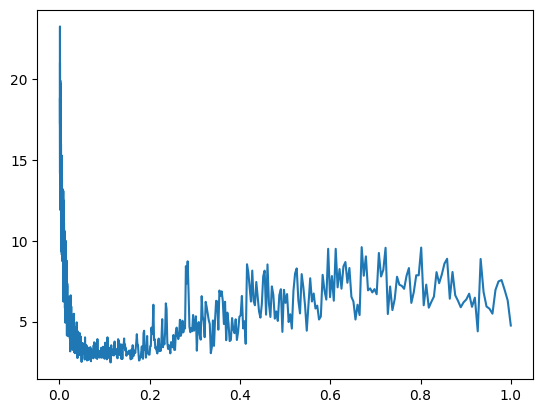

In [17]:
from matplotlib import pyplot as plt

plt.plot(lri, lossi)

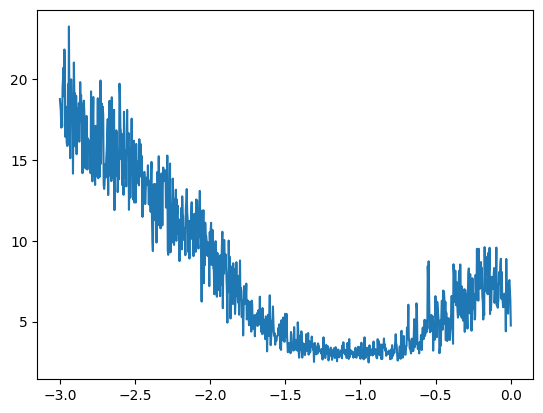

In [18]:
plt.plot(lri_exp, lossi)

so 10^-0.7 seems to be a nice spot

### test/train/validation split

80% - training set
10% - validation set (to tune hyperparams like the number of neurons in hidden layer, learning rate, etc)
10% - test set (to test the final model)

In [19]:
# building the dataset. taking three chars at a time, and assigning the output label as the fourth char

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [20]:
def train(X, Y, dim=2, context=3):
    lossi = []
    stepi = []
    
    for p in params:
        p.requires_grad = True

    for i in range(10000):
        # running minibatches here to save time
        # the gradient is less accurate since # of examples is small but accurate enough
        ix = torch.randint(0, X.shape[0], (32,))

        # FORWARD PASS
        emb = C[X[ix]]
        # to introduce non-linearity, ensuring that the network is not a linear function at the end of the day
        h = torch.tanh(emb.view(-1, context * dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])

        # BACKWARD PASS
        for p in params:
            p.grad = None
        loss.backward()

        # UPDATE WEIGHTS
        for p in params:
            p.data += -0.1 * p.grad
        # print(loss.item()) removed for excessive logging

        # TRACKING
        stepi.append(i)
        lossi.append(loss.item())

    return lri, lossi, lri_exp, stepi

since training loss is similar to validation loss, the model is underfitting and we could do better with more params

In [21]:
def check_loss(X, Y, dim=2, context=3):
    emb = C[X]
    h = torch.tanh(emb.view(-1, context * dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [22]:
# reset cell with new params
C = torch.randn((27, 2))
W1 = torch.randn((6, 300))
b1 = torch.randn((300))
W2 = torch.randn((300, 27))
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

10281

In [23]:
lri, lossi, lri_exp, stepi = train(Xtrain, Ytrain)
check_loss(Xval, Yval)

2.7547037601470947

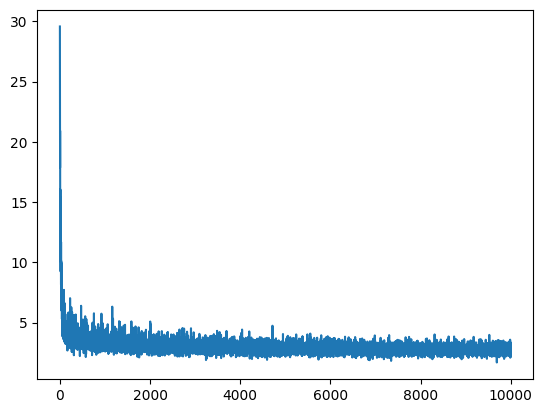

In [24]:
plt.plot(stepi, lossi)

lets take a look at the embeddings

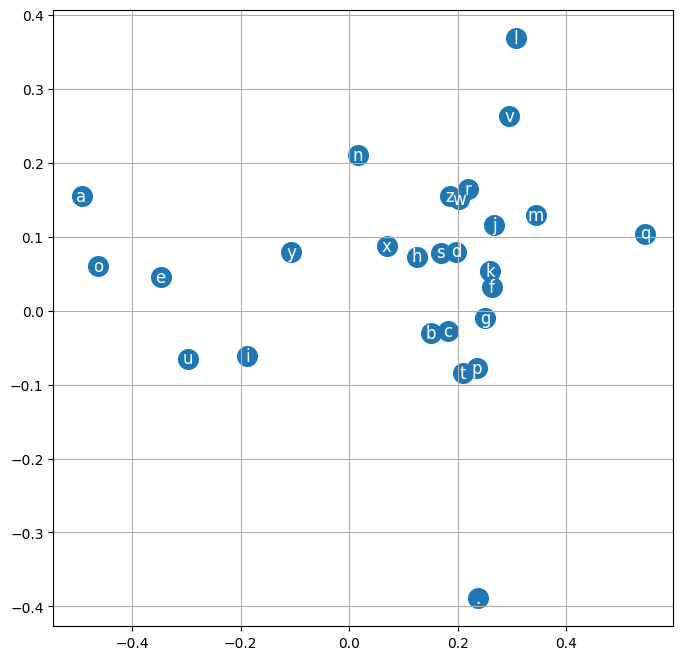

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha="center", va="center", fontsize=12, color="white")
plt.grid("minor")


notice how the model learnt that vowels are similar by clustering them together

the model is also not learning effectively enough because the number of dimensions is too small.

In [26]:
# reset cell with new params
C = torch.randn((27, 10)) # now 10 dimensions
W1 = torch.randn((30, 200)) # 3 * 10 dimensions -> 30
b1 = torch.randn((200))
W2 = torch.randn((200, 27)) # reduced hidden layer neurons
b2 = torch.randn((27))
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

11897

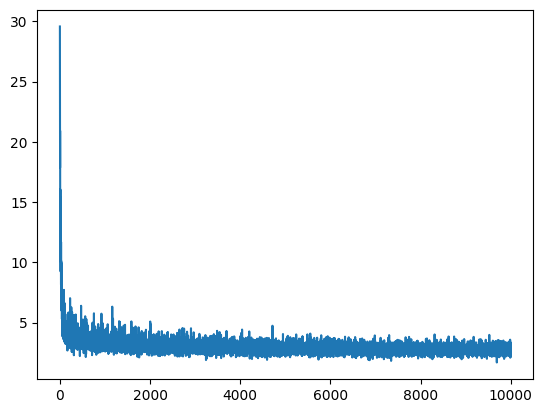

In [27]:
train(Xtrain, Ytrain, dim=10, context=3)
plt.plot(stepi, lossi)

In [28]:
check_loss(Xval, Yval, dim=10, context=3)


2.660649538040161

sampling from the model

In [29]:
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))
        

lan.
aadarah.
taf.
dar.
ararahlyearla.
